In this tutorial we will create an image stiching. Image Stiching is a technique to combine multiple images in one image, by matching their features and blend them together. It could be useful for example for taking a panorama picture, you will take many picture, each having some overlap with eachother. Then this code will create a single image showing the whole panorama.

These are the steps for stiching images together:
1. Take a series of interesting overlapping photos.
2. Detect **feature points** from the images and match the feature points. You can use a library function, such as AKAZE, *SIFT*, ORB, etc.
3. Assign a unique index i to each track. Then you can have {x_i, y_i} for N feature points for the series of input images.
4. Estimate a transform for each image using the **linear solution**. Try every tranform: translation, similarity, and affine as the motion model.
For perspective transform (homography), use OpenCV function cv2.getPerspectiveTransformm
5. Compute the size of the resulting **composite canvas**.
6. **Warp** each image into its final position on the canvas. cv2.warpPerspective
7. Average all of the images.

## Feature matching

We decided to use ORB for feature matching, there is no a particular reason.
ORB stands for Oriented FAST and Rotated BRIEF. It finds keypoints, and encodes the descriptor as binary strings.

In [356]:
import cv2
import numpy as np

# Load the images
image1 = cv2.imread('14.jpg')
image1 = cv2.resize(image1, (400, 600))
image2 = cv2.imread('15.jpg')
image2 = cv2.resize(image2, (400, 600))


# Detect ORB keypoints and descriptors
orb = cv2.ORB_create()
keypoints1, descriptors1 = orb.detectAndCompute(image1, None)
keypoints2, descriptors2 = orb.detectAndCompute(image2, None)

# Draw keypoints on the images
image1_keypoints = cv2.drawKeypoints(image1, keypoints1, None)
image2_keypoints = cv2.drawKeypoints(image2, keypoints2, None)

# Display the images with keypoints
cv2.imshow('Image 1 with Keypoints', image1_keypoints)
cv2.imwrite('./report_images/image1_keypoints.jpg', image1_keypoints)
cv2.imshow('Image 2 with Keypoints', image2_keypoints)
cv2.imwrite('./report_images/image2_keypoints.jpg', image2_keypoints)
cv2.waitKey(0)
cv2.destroyAllWindows()


After detecting the keypoints and finding their descriptors, we have to match the feature, so to understand for each point of image1, where is mapped into image2.

We can do this in multiple ways, the first one the **brute force matching**.
Brute forcing simply consist in checking for every descriptor, which descriptor is the best match. It checks every couple of descriptor and therefore is O(n^2), which is computationally expensive. 
It fits small usecases where there are not many descriptors.

In [357]:
# Create the bf matcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(descriptors1, descriptors2)

The BF matcher is initialized with NORM_HAMMING, which is the algorithm to compute distances between binary descriptors. NORM_HAMMING is best suited for ORB, BRIEF, BRISK, while NORM_L2 for SIFT and SURF.
crossCheck is an additional check it's performed during matching.

If we want a faster algorithm, we can use the FLANN. FLANN is faster but as a trade-off it is an approximate algorithm, meaning that finding the best solution is not guaranteed.

In FLANN we define the index_params which are the parameters for indexing of the search strategy. We can select the appropriate algorithm from 1 to 6. For binary descriptors like ORB the best matching strategy is Locality Sensitive Hashing (LHS). 

Note: with float descriptors, we can use the other 5 algorithms, for example the algorithm 1 which uses KD-tree.

In [287]:
# Initialize the feature matcher using FLANN matching, LHS
index_params = dict(algorithm=6, table_number=6, key_size=12, multi_probe_level=1)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Match the descriptors using FLANN matching
matches = flann.match(descriptors1, descriptors2)

flann.match find the best match for each descriptor but in some cases it could happen that there are *false positive* meaning descriptors which are very similar but they just are from different parts of the image, this is more common in more complex images or pattern-like images. 

To avoid this we can use the **K-Nearest Neighboor** algorithm to find lists of matches per each descriptor and then apply the **Lowe's ratio test** to filter good matches. 

The idea is: take the 2 best matches for each descriptor, then check how different are the first best match and the second best match: are they very close? In this case it could mean that the match is not good enough, on the other hand if the best match is much better than the second best match, we can assume it's not a false positive.

In [288]:
# Match descriptors using KNN
matches_knn = flann.knnMatch(descriptors1, descriptors2, k=2)

# Apply Lowe's ratio test to filter good matches
good_matches = []
for m, n in matches_knn:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

matches = good_matches

After we found the matches, we just draw them using the built-in function cv2.drawMatches

In [360]:
# Sort the matches by distance (lower is better)
matches = sorted(matches, key=lambda x: x.distance)

# Draw the top N matches
num_matches = 100
image_matches_flann = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:num_matches], None)

cv2.imshow('FLANN Matching', image_matches_flann)
cv2.imwrite('./report_images/matching.jpg', image_matches_flann)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Appendix A: best matches and KNN Lowe's filter

Let's try test the difference between the best-match approach and the KNN with Lowe's filter approach. We will use and image with a pattern so that there could be many false positives.

In [386]:
import cv2
import numpy as np

# Load the images
image1_pattern = cv2.imread('image1_pattern.jpg')
image1_pattern = cv2.resize(image1_pattern, (400, 600))

image2_pattern = cv2.imread('image2_pattern.jpg')
image2_pattern = cv2.resize(image2_pattern, (400, 600))



# Detect ORB keypoints and descriptors
orb = cv2.ORB_create()
keypoints1_pattern, descriptors1_pattern = orb.detectAndCompute(image1_pattern, None)
keypoints2_pattern, descriptors2_pattern = orb.detectAndCompute(image2_pattern, None)

# Draw keypoints on the images
image1_pattern_keypoints = cv2.drawKeypoints(image1_pattern, keypoints1_pattern, None)
image2_pattern_keypoints = cv2.drawKeypoints(image2_pattern, keypoints2_pattern, None)


# Initialize the feature matcher using FLANN matching, LHS
index_params = dict(algorithm=6, table_number=6, key_size=12, multi_probe_level=1)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Match the descriptors using FLANN matching
matches = flann.match(descriptors1_pattern, descriptors2_pattern)

# Sort the matches by distance (lower is better)
matches = sorted(matches, key=lambda x: x.distance)

# Draw the top N matches
num_matches = 50
image_matches_flann_pattern = cv2.drawMatches(image1_pattern, keypoints1_pattern, image2_pattern, keypoints2_pattern, matches[:num_matches], None)

cv2.imshow('FLANN Matching with pattern', image_matches_flann_pattern)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [387]:
# Get matched keypoints
points1_pattern = np.array([keypoints1_pattern[m.queryIdx].pt for m in matches]).reshape(-1, 2)
points2_pattern = np.array([keypoints2_pattern[m.trainIdx].pt for m in matches]).reshape(-1, 2)

M, _ = cv2.findHomography(points1_pattern, points2_pattern, cv2.RANSAC, 5.0)

# Warp image1 to image2's plane
height1, width1, channels1 = image1_pattern.shape
height2, width2, channels2 = image2_pattern.shape

# Create the composite canvas
canvas_height = max(height1, height2)
canvas_width = width1 + width2
canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)

# Place image2 on the canvas
canvas[0:height2, 0:width2] = image2_pattern

# Warp image1
warped_image1 = cv2.warpPerspective(image1_pattern, M, (canvas_width, canvas_height))

# Overlay the warped image on the canvas
overlay_indices = np.where(warped_image1 > 0)
canvas[overlay_indices] = warped_image1[overlay_indices]

# Display the composite image
cv2.imshow('Composite Image', canvas)
cv2.waitKey(0)
cv2.destroyAllWindows()

We clearly see that the image stiching didn't go as expected: the image is totally wrong. This is due to the fact that there are a lot of **false positives** therefore many matches are wrong.

Now let's try the same code using the **KNN Lowe's filter** approach.

In [388]:
# Initialize the feature matcher using FLANN matching, LHS
index_params = dict(algorithm=6, table_number=6, key_size=12, multi_probe_level=1)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Match descriptors using KNN
matches_knn = flann.knnMatch(descriptors1, descriptors2, k=2)

# Apply Lowe's ratio test to filter good matches
good_matches = []
for m, n in matches_knn:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

matches = good_matches

# Sort the matches by distance (lower is better)
matches = sorted(matches, key=lambda x: x.distance)

# Draw the top N matches
num_matches = 50
image_matches_flann_pattern = cv2.drawMatches(image1_pattern, keypoints1_pattern, image2_pattern, keypoints2_pattern, matches[:num_matches], None)


cv2.imshow('FLANN Matching with pattern', image_matches_flann_pattern)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [389]:
# Get matched keypoints
points1_pattern = np.array([keypoints1_pattern[m.queryIdx].pt for m in matches]).reshape(-1, 2)
points2_pattern = np.array([keypoints2_pattern[m.trainIdx].pt for m in matches]).reshape(-1, 2)

M, _ = cv2.findHomography(points1_pattern, points2_pattern, cv2.RANSAC, 5.0)

# Warp image1 to image2's plane
height1, width1, channels1 = image1_pattern.shape
height2, width2, channels2 = image2_pattern.shape

# Create the composite canvas
canvas_height = max(height1, height2)
canvas_width = width1 + width2
canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)

# Place image2 on the canvas
canvas[0:height2, 0:width2] = image2_pattern

# Warp image1
warped_image1 = cv2.warpPerspective(image1_pattern, M, (canvas_width, canvas_height))

# Overlay the warped image on the canvas
overlay_indices = np.where(warped_image1 > 0)
canvas[overlay_indices] = warped_image1[overlay_indices]

# Display the composite image
cv2.imshow('Composite Image', canvas)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
import cv2
import numpy as np

# Read the images
image1 = cv2.imread('image1.jpg')  # Image with the object
image2 = cv2.imread('image2.jpg')  # Reference image with the drawing pattern

# Convert images to grayscale
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Detect ORB keypoints and descriptors
orb = cv2.ORB_create(nfeatures=10000)
keypoints1, descriptors1 = orb.detectAndCompute(gray1, None)
keypoints2, descriptors2 = orb.detectAndCompute(gray2, None)

# Initialize the feature matcher using FLANN matching with LSH
index_params = dict(algorithm=6, table_number=6, key_size=12, multi_probe_level=1)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Match descriptors using KNN
matches_knn = flann.knnMatch(descriptors1, descriptors2, k=2)

# Apply Lowe's ratio test to filter good matches
ratio_test_threshold = 0.75  # Adjust this threshold if necessary
good_matches = []
for m, n in matches_knn:
    if m.distance < ratio_test_threshold * n.distance:
        good_matches.append(m)

matches = good_matches

# If not enough matches, reduce the threshold
if len(matches) < 10:
    print("Reducing threshold to find more matches")
    ratio_test_threshold = 0.8
    good_matches = []
    for m, n in matches_knn:
        if m.distance < ratio_test_threshold * n.distance:
            good_matches.append(m)
    matches = good_matches

# Ensure there are enough good matches
if len(matches) < 4:
    raise ValueError("Not enough good matches found")

# Sort the matches by distance (lower is better)
matches = sorted(matches, key=lambda x: x.distance)

# Draw the top N matches
num_matches = min(len(matches), 50)
image_matches_flann = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:num_matches], None)

cv2.imshow('FLANN Matching with Lowe\'s Ratio Test', image_matches_flann)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Get matched keypoints
points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Find homography matrix
M, mask = cv2.findHomography(points1, points2, cv2.RANSAC, 5.0)

# Warp image1 to image2's plane
height1, width1 = image1.shape[:2]
height2, width2 = image2.shape[:2]

# Create the composite canvas
canvas_height = max(height1, height2)
canvas_width = width1 + width2
canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)

# Place image2 on the canvas
canvas[0:height2, 0:width2] = image2

# Warp image1
warped_image1 = cv2.warpPerspective(image1, M, (canvas_width, canvas_height))

# Blend the images together
blend_mask = (warped_image1 > 0).astype(np.uint8)
canvas = cv2.addWeighted(canvas, 1, warped_image1, 1, 0)

# Display the composite image
cv2.imshow('Composite Image', canvas)
cv2.waitKey(0)
cv2.destroyAllWindows()


## Estimation

After matching the features, we have to estimate the matrix of the transformation of the 2 images, this can be:
1. Translation
2. Euclidean
3. Similarity
4. Affine
5. Homography (Projective)

For each transformation you have a different number of parameters in the matrix:
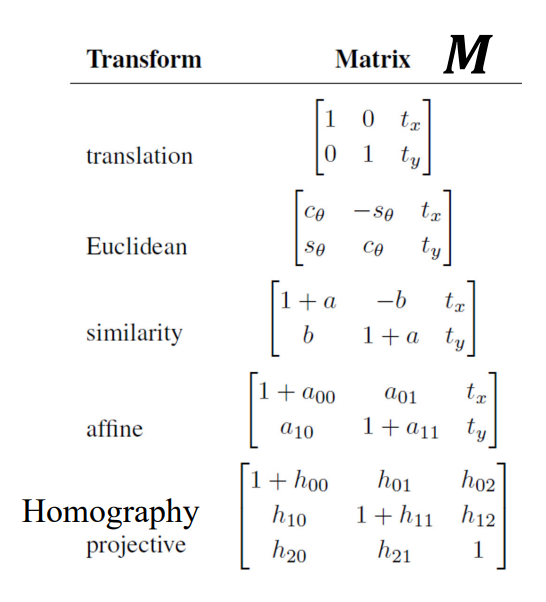

Note: Euclidean is particurarly difficult to calculate, so we will omit here.

In [375]:
# Get matched keypoints
points1 = np.array([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 2)
points2 = np.array([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 2)

N = len(points1)
A = [[N, 0], [0, N]]

b = np.zeros(2)
for i in range(N):
    b[0] += points2[i][0] - points1[i][0]
    b[1] += points2[i][1] - points1[i][1]

# Solve for t_x and t_y using least squares
t, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
t_x, t_y = t

# Create the translation matrix
translation_matrix = np.array([[1, 0, t_x], [0, 1, t_y]], dtype=np.float32)

M = translation_matrix

print(f'\ntx = {M[0][2]}, ty = {M[1][2]}')


tx = 158.4423828125, ty = -1.4005852937698364


Now let's try to estimate the **similarity** matrix. In this case we use the built-in function cv2.estimateAffinePartial2D

In [373]:
M, _ = cv2.estimateAffinePartial2D(points1, points2)
print(M)
print(f'\na = {M[0][0] - 1} \nb = {M[1][0]}\ntx = {M[0][2]}, ty = {M[1][2]}')

[[ 1.00396329e+00 -2.49256823e-02  1.98663420e+02]
 [ 2.49256823e-02  1.00396329e+00 -2.14778195e+00]]

a = 0.003963290329415559 
b = 0.024925682289475375
tx = 198.66342036531213, ty = -2.147781953051249


For the **affine** matrix, we use the method cv2.estimateAffine2D

In [380]:
M, _ = cv2.estimateAffine2D(points1, points2)
print(f'\na_00 = {M[0][0] - 1} \na_01 = {M[0][1]}\na_10 = {M[1][0]}\na_11 = {M[1][1] - 1}\ntx = {M[0][2]}, ty = {M[1][2]}')


a_00 = -0.024617029277109292 
a_01 = -0.03139427610880056
a_10 = 0.024767967799047164
a_11 = 0.005824122907354123
tx = 203.27782835109264, ty = -2.646308436338277


Now let's warp the image1 into image 2 using the found matrix and display it

In [378]:
# Apply the translation to image1
image2_translation = cv2.warpAffine(image1, M, (image2.shape[1] + 400, image2.shape[0] + 400))

# Display the translated image using OpenCV
cv2.imshow('Translated Image', image2_translation)
cv2.imwrite('partial_result_aff.jpg', image2_translation)
cv2.waitKey(0)
cv2.destroyAllWindows()

For the **homography** we use the method cv2.findHomography

In [381]:
M, _ = cv2.findHomography(points1, points2, cv2.RANSAC, 5.0)
print(f'\nh_00 = {M[0][0] - 1} \nh_01 = {M[0][1]}\nh_02 = {M[0][2]}\nh_10 = {M[1][0]}\nh_11 = {M[1][1] - 1}\nh_12 = {M[1][2]}\nh_20 = {M[2][0]}\nh_21 = {M[2][1]}\nh_22 = 1')


h_00 = -0.23695713803779095 
h_01 = -0.03477742110600691
h_02 = 206.0553635068483
h_10 = -0.13849575161869057
h_11 = -0.07402042410528076
h_12 = 17.94908548505482
h_20 = -0.0005690796643455097
h_21 = -3.0416416230833144e-05
h_22 = 1


Now let's warp the image with the homography matrix. We will use the built-in function cv2.warpPerspective

In [385]:
warped_image1 = cv2.warpPerspective(image1, M, (canvas_width + 100, canvas_height+200))

# Display the translated image using OpenCV
cv2.imshow('Translated Image', warped_image1)
cv2.imwrite('warped_image1_homo.jpg', warped_image1)
cv2.waitKey(0)
cv2.destroyAllWindows()

Now we calculate the composite canvas size, we warp the image and we display the stitched images.

In [331]:
# Warp image1 to image2's plane
height1, width1, channels1 = image1.shape
height2, width2, channels2 = image2.shape

# Create the composite canvas
canvas_height = height1 + height2
canvas_width = width1 + width2
canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)

# Place image2 on the canvas
canvas[0:height2, 0:width2] = image2

# Warp image1
warped_image1 = cv2.warpPerspective(image1, M, (canvas_width, canvas_height))

# Overlay the warped image on the canvas
overlay_indices = np.where(warped_image1 > 0)
canvas[overlay_indices] = warped_image1[overlay_indices]

# Display the composite image
cv2.imshow('Composite Image', canvas)
cv2.imwrite('final stiching.jpg', canvas)
cv2.waitKey(0)
cv2.destroyAllWindows()